- (First part based on previous research) films examined for male bias based on scripts/dialogue
    - male character line count, etc
    - and/or number of male characters (“above the line” talent)
- add in rotten tomatoes score for analysis of critical/journalistic/more academic reception 
- add in oscar nominations/wins for analysis of professional/peer reception 
- join these datasets based on movie title and year
- model relationships between these variables (step 1 predictor, steps 2 & 3 response) 

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# # Dialogue set from Cornell Movie-Dialogs Corpus
# # For manual result recreation, if necessary

# # Lines data
# lines_raw = pd.read_csv("dialogue/movie_lines.tsv", header=None, names=["raw"])
# lines_split = lines_raw["raw"].str.split("\t", expand=False)

# fixed_rows = []
# for row in lines_split:
#     if len(row) > 5:
#         row = row[:4] + [" ".join(row[4:])]
#     elif len(row) < 5:
#         row += [None] * (5 - len(row))
#     fixed_rows.append(row)

# lines = pd.DataFrame(fixed_rows, columns=["lineID", "characterID", "movieID", "characterName", "text"])

# # Character data
# characters_raw = pd.read_csv("dialogue/movie_characters_metadata.tsv", header=None, names=["raw"])
# characters_split = characters_raw["raw"].str.split("\t", expand=False)

# fixed_rows = []
# for row in characters_split:
#     if len(row) > 6:
#         row = row[:4] + [" ".join(row[4:])]
#     elif len(row) < 6:
#         row += [None] * (6 - len(row))
#     fixed_rows.append(row)

# characters = pd.DataFrame(fixed_rows, columns=["characterID", "characterName", "movieID", "movieTitle", "gender", "creditPosition"])

# # Movie data
# pd_movies = pd.read_csv("dialogue/movie_titles_metadata.tsv", header=None, delimiter="\t", names=["movieID", "title", "year", "imdbRating", "imdbVotes", "genres"])

# # recreate gender analysis:
# # lines: break down to tokens/word count
# # aggregate number of lines/rows per character
# # join on chars 
# # agg per movie based on char gender

In [ ]:
# Using NLTK to tokenize text
# import nltk
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize
# lines["tokens"] = lines["text"].apply(lambda x: word_tokenize(x) if pd.notnull(x) else [])
# lines["token_count"] = lines["tokens"].apply(len)
# lines["word_count"] = lines["text"].apply(lambda x: len(x.split()) if pd.notnull(x) else 0)

In [97]:
# The Pudding's script gender analysis dataset:

gender_data = pd.read_csv("pudding/character_list5.csv", header=0, encoding="latin-1")
script_metadata = pd.read_csv("pudding/meta_data7.csv", header=0, encoding="latin-1")

gender_raw = gender_data.merge(script_metadata, how="left", on="script_id")
gender = gender_raw[["imdb_character_name", "words", "gender", "age", "title", "year"]].copy()

gender.loc[:, "title"] = gender["title"].str.replace(r'[^A-Za-z0-9 ]', '', regex=True).str.lower().str.strip()
gender["gender"] = gender["gender"].astype("category")
gender = gender.rename(columns={"imdb_character_name": "character"})

print(gender.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23048 entries, 0 to 23047
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   character  23046 non-null  object  
 1   words      23048 non-null  int64   
 2   gender     23048 non-null  category
 3   age        18263 non-null  float64 
 4   title      23048 non-null  object  
 5   year       23048 non-null  int64   
dtypes: category(1), float64(1), int64(2), object(2)
memory usage: 923.1+ KB
None


In [98]:
# Rotten Tomatoes dataset

rt_raw = pd.read_csv("rt/rotten_tomatoes_movies.csv", header=0)
rt = rt_raw[["tomatometer_rating", "tomatometer_count", "tomatometer_top_critics_count", "tomatometer_fresh_critics_count", "tomatometer_rotten_critics_count"]].copy()

rt["title"] = rt_raw["movie_title"].str.replace(r'[^A-Za-z0-9 ]', '', regex=True).str.lower().str.strip()
rt["year"] = pd.to_datetime(rt_raw["original_release_date"]).dt.year
rt["tomatometer_status"] = rt_raw["tomatometer_status"].astype("category")

# print(rt.isnull().sum())
print(rt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17712 entries, 0 to 17711
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   tomatometer_rating                17668 non-null  float64 
 1   tomatometer_count                 17668 non-null  float64 
 2   tomatometer_top_critics_count     17712 non-null  int64   
 3   tomatometer_fresh_critics_count   17712 non-null  int64   
 4   tomatometer_rotten_critics_count  17712 non-null  int64   
 5   title                             17712 non-null  object  
 6   year                              16546 non-null  float64 
 7   tomatometer_status                17668 non-null  category
dtypes: category(1), float64(3), int64(3), object(1)
memory usage: 986.2+ KB
None


In [99]:
# Oscars dataset

oscars_raw = pd.read_csv("oscars/the_oscar_award.csv", header=0)
oscars = oscars_raw[["winner"]].copy()

oscars["title"] = oscars_raw["film"].str.replace(r'[^A-Za-z0-9 ]', '', regex=True).str.lower().str.strip()
oscars["year"] = pd.to_datetime(oscars_raw["year_film"]).dt.year
oscars["award"] = oscars_raw["canon_category"].astype("category")

# print(oscars.isnull().sum())
oscars = oscars.dropna(subset=["title"])

print(oscars.info())

<class 'pandas.core.frame.DataFrame'>
Index: 10751 entries, 0 to 11105
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   winner  10751 non-null  bool    
 1   title   10751 non-null  object  
 2   year    10751 non-null  int32   
 3   award   10751 non-null  category
dtypes: bool(1), category(1), int32(1), object(1)
memory usage: 233.5+ KB
None


In [100]:
# Join on title and year for review data
gender_rt = pd.merge(gender, rt, on=["title", "year"], how="inner")
print(gender_rt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18896 entries, 0 to 18895
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   character                         18894 non-null  object  
 1   words                             18896 non-null  int64   
 2   gender                            18896 non-null  category
 3   age                               15149 non-null  float64 
 4   title                             18896 non-null  object  
 5   year                              18896 non-null  int64   
 6   tomatometer_rating                18891 non-null  float64 
 7   tomatometer_count                 18891 non-null  float64 
 8   tomatometer_top_critics_count     18896 non-null  int64   
 9   tomatometer_fresh_critics_count   18896 non-null  int64   
 10  tomatometer_rotten_critics_count  18896 non-null  int64   
 11  tomatometer_status                18891 non-null  cate

In [110]:
# Join on title and year for Academy Award data
oscars_full = pd.merge(gender, oscars, on=["title", "year"], how="inner")

# Split into wins and nominations
# oscars_wins = oscars_full[oscars_full["winner"] == True].copy()
# oscars_noms = oscars_full[oscars_full["winner"] == False].copy()

# Split acting vs non-acting awards due to inherent gendering
if_act = oscars_full["award"].str.contains("ACTOR|ACTRESS|SUPPORTING", case=False, na=False)

oscars_acting = oscars_full[if_act] # acting awards
oscars_other = oscars_full[~if_act] # all other awards

print(oscars_full.info())
print(len(oscars_acting))
print(len(oscars_other))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   character  101 non-null    object  
 1   words      101 non-null    int64   
 2   gender     101 non-null    category
 3   age        87 non-null     float64 
 4   title      101 non-null    object  
 5   year       101 non-null    int64   
 6   winner     101 non-null    bool    
 7   award      101 non-null    category
dtypes: bool(1), category(2), float64(1), int64(2), object(2)
memory usage: 7.0+ KB
None
31
70


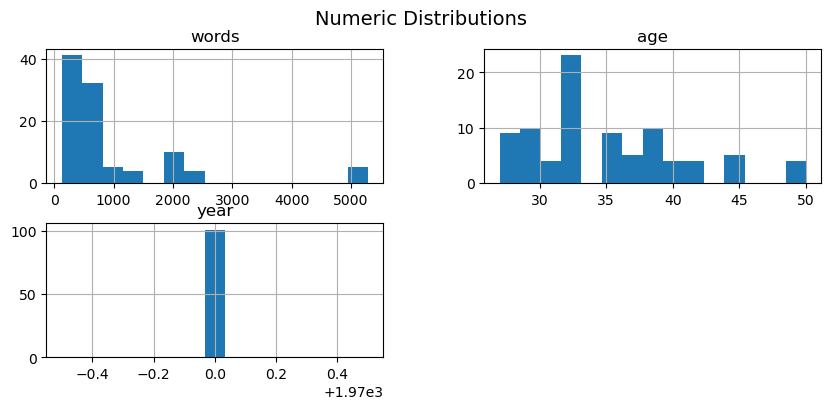

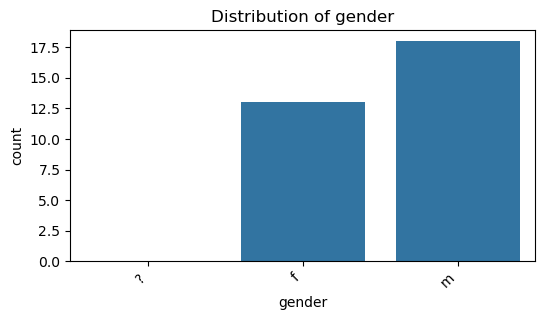

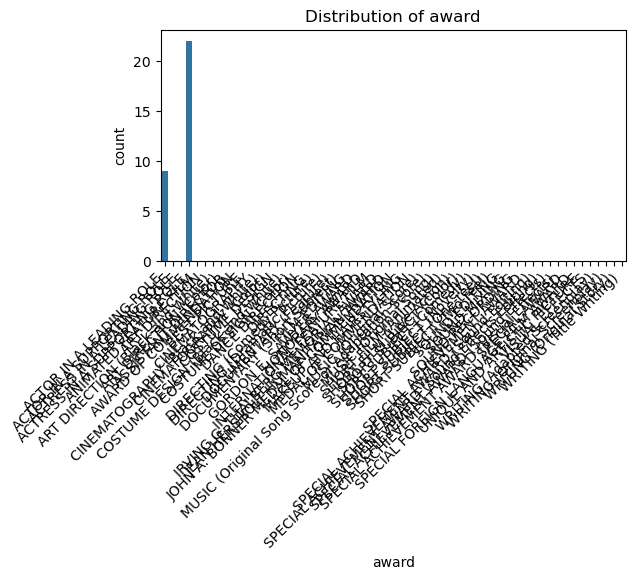

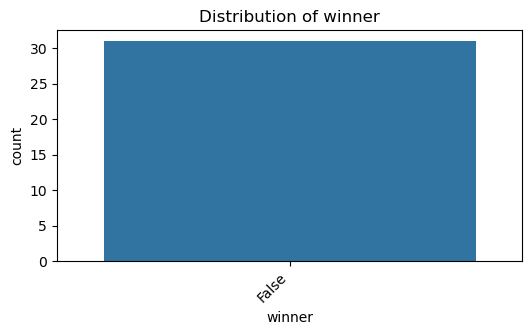

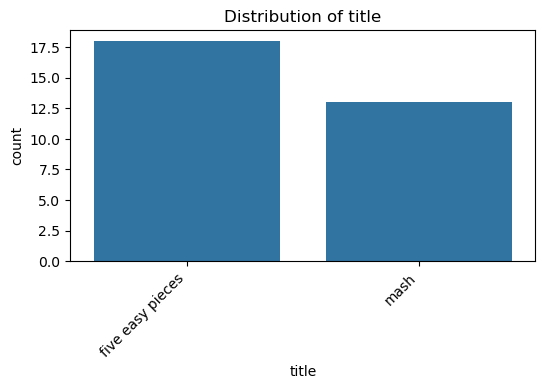

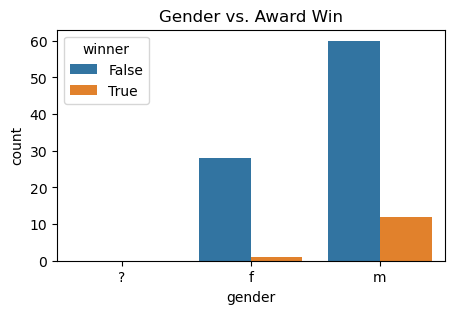

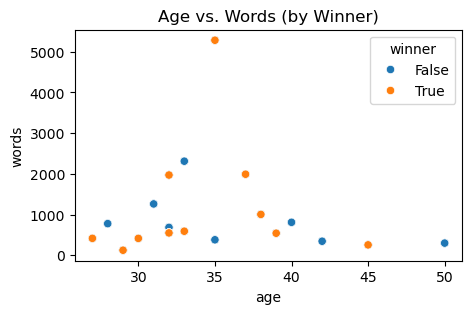

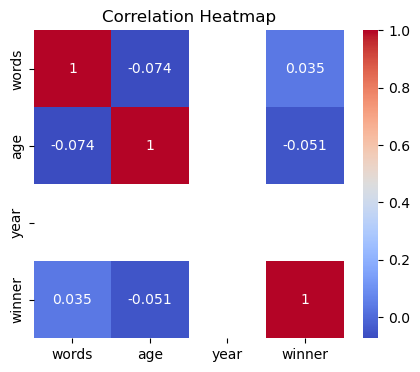

In [111]:

numeric_cols = ["words", "age", "year"]
oscars_full[numeric_cols].hist(bins=15, figsize=(10, 4))
plt.suptitle("Numeric Distributions", fontsize=14)
plt.show()

cat_cols = ["gender", "award", "winner", "title"]
# for col in cat_cols:
#     plt.figure(figsize=(6, 3))
#     sns.countplot(data=oscars_other, x=col)
#     plt.title(f"Distribution of {col}")
#     plt.xticks(rotation=45, ha="right")
#     plt.show()

for col in cat_cols:
    plt.figure(figsize=(6, 3))
    sns.countplot(data=oscars_acting, x=col)
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45, ha="right")
    plt.show()

plt.figure(figsize=(5, 3))
sns.countplot(data=oscars_full, x="gender", hue="winner")
plt.title("Gender vs. Award Win")
plt.show()

plt.figure(figsize=(5, 3))
sns.scatterplot(data=oscars_full, x="age", y="words", hue="winner")
plt.title("Age vs. Words (by Winner)")
plt.show()

plt.figure(figsize=(5, 4))
sns.heatmap(oscars_full[numeric_cols + ["winner"]].corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()
